In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime
from collections import Counter

import torch

from pydub import AudioSegment
import ffmpeg
import librosa

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

This notebook contains basic analysis of metadata and the audio files themselves.

## 1. Loading metadata

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
META_PATH = os.path.join(DATA_PATH, 'Demo RAT discourse production.xlsx')
AUDIO_PATH = os.path.join(DATA_PATH, 'Voices')
APHASIA_PATH = os.path.join(AUDIO_PATH, "Aphasia")
NORM_PATH = os.path.join(AUDIO_PATH, "Norm")

In [3]:
aphasia_filenames = [x[:-4].split("-")[1] for x in os.listdir(APHASIA_PATH)]
norm_filenames = [x[:-4].split("-")[1] for x in os.listdir(NORM_PATH)]
norm_filenames = [x + '-НРАТ' if x[0] != "0" else x[1:] + '-НРАТ' for x in norm_filenames]

In [4]:
sum(list(Counter(aphasia_filenames).values()))

608

In [5]:
meta_data_aphasia = pd.read_excel(META_PATH, sheet_name='пациенты')
meta_data_norm = pd.read_excel(META_PATH, sheet_name='норма')

meta_data_norm.drop(meta_data_norm.index[-1], axis=0, inplace=True)
meta_data_aphasia.shape, meta_data_norm.shape

((353, 34), (101, 17))

In [6]:
meta_data_aphasia["Subj_ID"] = meta_data_aphasia["Subj_ID"].astype(str)

Keep only those whose audio recordings are present in the dataset

In [7]:
meta_data_aphasia = meta_data_aphasia[meta_data_aphasia.iloc[:, 1:2].isin(aphasia_filenames).any(axis=1)]
meta_data_aphasia.shape

(253, 34)

In [8]:
meta_data_norm = meta_data_norm[meta_data_norm.iloc[:, 0:1].isin(norm_filenames).any(axis=1)]
meta_data_norm.shape

(101, 17)

In [9]:
meta_data_aphasia.head()

,Unnamed: 0,Subj_ID,Date_of_birth,Age,Sex (m/f),Education in years,Education level,Stroke_date,Stroked hemisphere (L/R/LR),N of strokes,...,Time2.1_file_name,Time2.2_file_name,Time3.1_file_name,Time3.2_file_name,Time4.1_file_name,Time4.2_file_name,Time5.1_file_name,Time5.2_file_name,Time6.1_file_name,Time6.2_file_name
0,13-РАТ,1,1957-12-04 00:00:00,58.0,f,NaN,высшее,2005-03-27 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22-РАТ,7,1964-03-21 00:00:00,52.0,m,NaN,высшее,2006-06-20 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55-РАТ,13,1962-12-06 00:00:00,53.0,m,NaN,сред спец,2008-09-19 00:00:00,L,1.0,...,A-13-RAT-2-robb,NaN,A-13-RAT-3-robb,NaN,A-13-RAT-4-bike,NaN,NaN,NaN,NaN,NaN
3,Афанасенко СС,35,1963-10-21 00:00:00,53.0,m,NaN,сред спец,2011-09-27 00:00:00,L,1.0,...,A-35-RAT-2-bike,NaN,A-35-RAT-3-bike,A-35-RAT-3-robb,NaN,NaN,NaN,NaN,NaN,NaN
4,Муксеева ЕА,51,1971-09-22 00:00:00,45.0,f,NaN,высшее,2012-06-16 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
meta_data_norm.head()

,№,Порядок предъявления проб,Дата проведения РАТа,Возрастная группа,Дата рождения,Пол,Образование,Профессия,Место жительства,Рукость,Биллингвизм,Неврологические/психиатрические расстройства,Медицинские препараты,Проблемы со слухом/зрением,Комментарии,bike_file_name,robbery_file_name
0,901-НРАТ,2,28.08.2016,2,19.05.1972,м,ученая степень,военнослужащий,Москва,правша,нет,нет,нет,нет,в порядке предъявления 2 (для нечетных) сначал...,N-0901-RAT-1-bike,N-0901-RAT-1-robb
1,902-НРАТ,1,28.08.2016,3,1965,ж,среднее специальное,медцина,Москва,правша,нет,нет,нет,нет,NaN,N-0902-RAT-1-bike,N-0902-RAT-1-robb
2,903-НРАТ,2,30.08.2016,1,07.07.1995,ж,неоконченное высшее,студент,Санкт-Петербург,правша,нет,нет,нет,нет,NaN,N-0903-RAT-1-bike,N-0903-RAT-1-robb
3,904-НРАТ,1,06.09.2016,1,09.01.1994,ж,неоконченное высшее,лингвистика,Москва,правша,да(чувашский),нет,нет,нет,NaN,N-0904-RAT-1-bike,N-0904-RAT-1-robb
4,905-НРАТ,2,06.09.2016,1,03.10.1995,ж,неоконченное высшее,лингвистика,Химки,правша,нет,нет,нет,нет,NaN,N-0905-RAT-1-bike,N-0905-RAT-1-robb


In [11]:
meta_data_aphasia.columns

Index(['Unnamed: 0', 'Subj_ID', 'Date_of_birth', 'Age', 'Sex (m/f)',
       'Education in years', 'Education level', 'Stroke_date',
       'Stroked hemisphere (L/R/LR)', 'N of strokes',
       'Aphasia/Norm (A/N), A includes all patients, even with just dysarthria',
       'Aphasia_Severity \n0 - no aphasia\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe',
       'Aphasia_Types\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other',
       'Dominant_Aphasia\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other',
       'Dysarthria (1/0)',
       'Dysarthria_Severity \n0 - no dysarthria\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe',
       'Time1_date', 'Time2_date', 'Time3_date', 'Time4_date', 'Time5_date',
    

Rename the columns.

In [12]:
meta_data_aphasia.rename(columns={'Stroked hemisphere (L/R/LR)': 'Stroked hemisphere',
                          'Aphasia/Norm (A/N), A includes all patients, even with just dysarthria': 'Aphasia/Norm', 
                          'Aphasia_Severity \n0 - no aphasia\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe': 'Aphasia_Severity',
                          'Aphasia_Types\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other': 'Aphasia_Types',
                          'Dominant_Aphasia\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other': 'Dominant_Aphasia',
                          'Dysarthria (1/0)': 'Dysarthria',
                          'Dysarthria_Severity \n0 - no dysarthria\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe': 'Dysarthria_Severity',
                          }, inplace=True)

In the aphasia group there are quite a few missing values, but they are mainly related to subject name and education.

In [13]:
meta_data_aphasia.isna().sum()

Unnamed: 0              77
Subj_ID                  0
Date_of_birth            4
Age                      3
Sex (m/f)                4
Education in years     179
Education level         30
Stroke_date              3
Stroked hemisphere      14
N of strokes            16
Aphasia/Norm             0
Aphasia_Severity        10
Aphasia_Types            9
Dominant_Aphasia        11
Dysarthria               9
Dysarthria_Severity     11
Time1_date               4
Time2_date             148
Time3_date             191
Time4_date             203
Time5_date             250
Time6_date             251
Time1.1_file_name        5
Time1.2_file_name      163
Time2.1_file_name      158
Time2.2_file_name      229
Time3.1_file_name      195
Time3.2_file_name      243
Time4.1_file_name      211
Time4.2_file_name      247
Time5.1_file_name      248
Time5.2_file_name      253
Time6.1_file_name      251
Time6.2_file_name      252
dtype: int64

In the control group, missing values are only in date of birth, which is not critical.

In [14]:
meta_data_norm.isna().sum()

№                                                0
Порядок предъявления проб                        0
Дата проведения РАТа                             0
Возрастная группа                                0
Дата рождения                                    6
Пол                                              0
Образование                                      0
Профессия                                        0
Место жительства                                 0
Рукость                                          0
Биллингвизм                                      0
Неврологические/психиатрические расстройства     0
Медицинские препараты                            2
Проблемы со слухом/зрением                       2
Комментарии                                     70
bike_file_name                                   0
robbery_file_name                                0
dtype: int64

Судя по всему, каждый participant учтён таблицах единожды

In [15]:
PARTICIPANT_APHASIA_ID = meta_data_aphasia["Subj_ID"].tolist()
PARTICIPANT_NORM_ID = meta_data_norm["№"].tolist()

participant_count = len(PARTICIPANT_APHASIA_ID) + len(PARTICIPANT_NORM_ID)
print("Count of aphasia participants: ", len(PARTICIPANT_APHASIA_ID))
print("Count of normal participants: ", len(PARTICIPANT_NORM_ID))
print("Count of participants:", participant_count)

Count of aphasia participants:  253
Count of normal participants:  101
Count of participants: 354


## 2. Demographic data

### 2.1 Возраст

In [16]:
meta_data_norm.columns 

Index(['№', 'Порядок предъявления проб', 'Дата проведения РАТа',
       'Возрастная группа', 'Дата рождения', 'Пол', 'Образование', 'Профессия',
       'Место жительства', 'Рукость', 'Биллингвизм',
       'Неврологические/психиатрические расстройства', 'Медицинские препараты',
       'Проблемы со слухом/зрением', 'Комментарии', 'bike_file_name',
       'robbery_file_name'],
      dtype='object')

In [17]:
meta_data_norm.iloc[64, 4] = "30.11.1948"   # В данных есть артефакты

age_group = [24, 40, 55, 65, 71]

In [18]:
def get_age(df: pd.DataFrame, first_data: str, second_data: str, group_columns: str = None) -> pd.Series:
    age = []
    for i, row in df.iterrows():
        if pd.isnull(row[first_data]) or pd.isnull(row[second_data]):
            if group_columns is None:
                age.append(None)
            else:
                age.append(age_group[int(row[group_columns]) - 1])
            continue
            
        data_1 = [int(x) for x in str(row[first_data]).strip().split('.')]
        data_2 = [int(x) for x in str(row[second_data]).strip().split('.')]
        
        year_1 = data_1[-1]
        year_2 = data_2[-1]
        age.append(int(year_2 - year_1))
        if len(data_1) > 1 and len(data_2) > 1:
            age[-1] -= int(((data_2[0] < data_1[0]) and (data_2[1] < data_1[1])))
    
    return pd.Series(age, name="Возраст")

In [19]:
meta_data_norm["Возраст"] = get_age(meta_data_norm, "Дата рождения", "Дата проведения РАТа", "Возрастная группа")

In [20]:
meta_data_norm["Возраст"].describe()

count    101.000000
mean      48.712871
std       18.032935
min       19.000000
25%       35.000000
50%       51.000000
75%       63.000000
max       86.000000
Name: Возраст, dtype: float64

In [21]:
meta_data_aphasia["Age"] = meta_data_aphasia["Age"].fillna(meta_data_aphasia["Age"].mean()).astype(int)

Статистики для возраста (с афазией).

In [22]:
meta_data_aphasia["Age"].describe()

count    253.000000
mean      57.948617
std       10.720536
min       25.000000
25%       52.000000
50%       59.000000
75%       66.000000
max       82.000000
Name: Age, dtype: float64

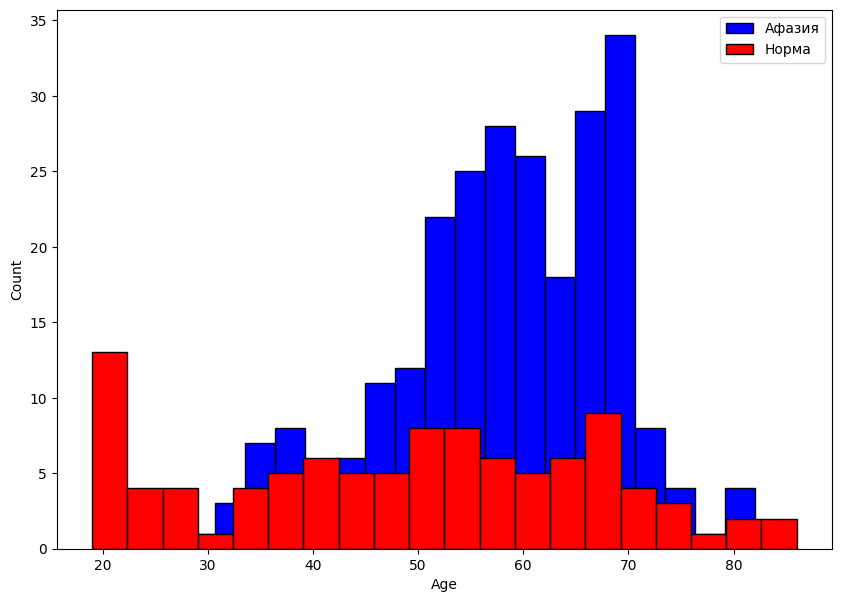

In [23]:
plt.figure(figsize=(10, 7))
plt.hist(meta_data_aphasia["Age"], bins=20, color="blue", label="Афазия", edgecolor='black')
plt.hist(meta_data_norm["Возраст"], bins=20, color="red", label="Норма", edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend();

Проверим на нормальность возраст больных афазией (нулевая гипотеза — данные распределены нормально).

In [24]:
stat, p_value = stats.kstest(meta_data_aphasia["Age"], 'norm', args=(np.mean(meta_data_aphasia["Age"]), np.std(meta_data_aphasia["Age"])))
print("Aphasia P-value: ", p_value)

Aphasia P-value:  0.10999312354402757


In [25]:
meta_data_aphasia["group"] = "aphasia"
meta_data_norm["group"] = "norm"

df_all = pd.concat([meta_data_aphasia[["Age", "group"]], meta_data_norm[["Возраст", "group"]].rename(columns={"Возраст": "Age", "group": "group"})], ignore_index=True)
df_all.head()

df_all["Age"] = df_all['Age'].map(lambda x: "[20; 30)" if x < 30 else "[30; 40)" 
                                  if x < 40 else "[40; 50)" if x < 50 else "[50; 60)" 
                                  if x < 60 else "[60; 70)" if x < 70 else "[70; 80)" 
                                  if x < 80 else "[80; 90)")

table = pd.crosstab(df_all['group'], df_all['Age'])

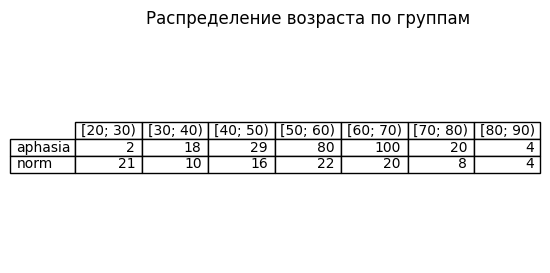

In [26]:
plt.figure(figsize=(6, 3))
plt.axis('off')
plt.table(cellText=table.values,
          colLabels=table.columns,
          rowLabels=table.index,
          loc='center')
plt.title('Распределение возраста по группам')
plt.show()

### 2.2 Пол

Посмотрим, какие значения бывают.

In [27]:
meta_data_aphasia["Sex (m/f)"].drop_duplicates().values, meta_data_norm["Пол"].drop_duplicates().values

(array(['f', 'm', nan, 'ff'], dtype=object), array(['м', 'ж'], dtype=object))

Почистим артефакты.

In [28]:
meta_data_aphasia["Sex (m/f)"] = meta_data_aphasia["Sex (m/f)"].apply(lambda x: "f" if x == "ff" else x)

In [29]:
meta_data_norm["Пол"] = meta_data_norm["Пол"].map({"м": "m", "ж": "f"}) 

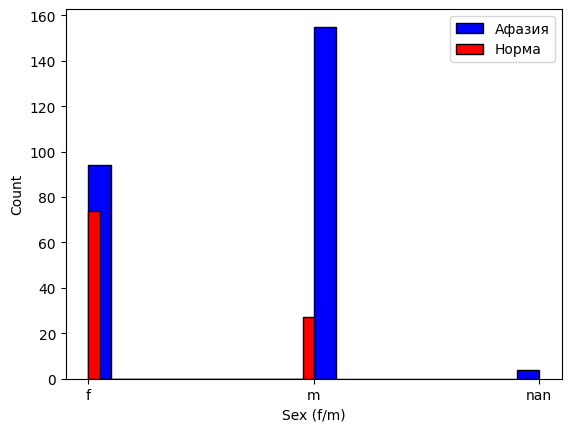

In [30]:
plt.hist(meta_data_aphasia["Sex (m/f)"].to_list(), bins=20, color="blue", label="Афазия", edgecolor='black')
plt.hist(meta_data_norm["Пол"].to_list(), bins=20, color="red", label="Норма", edgecolor='black')
plt.xlabel("Sex (f/m)")
plt.ylabel("Count")
plt.legend();

In [31]:
df_all = pd.concat([meta_data_aphasia[["Sex (m/f)", "group"]], meta_data_norm[["Пол", "group"]].rename(columns={"Пол": "Sex (m/f)", "group": "group"})], ignore_index=True)
df_all.head()

df_all["Sex (m/f)"] = df_all['Sex (m/f)'].map({"f": "female", "m": "male"})

table = pd.crosstab(df_all['group'], df_all['Sex (m/f)'], dropna=False)

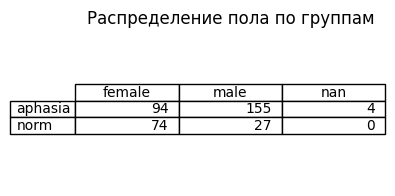

In [32]:
plt.figure(figsize=(4, 2))
plt.axis('off')
plt.table(cellText=table.values,
          colLabels=table.columns,
          rowLabels=table.index,
          loc='center')
plt.title('Распределение пола по группам')
plt.show()

### 2.3 Образование

Посмотрим на значения, видим, что очень много повторяющихся классов. Исправим это.

In [33]:
meta_data_aphasia["Education level"].drop_duplicates().values

array(['высшее', 'сред спец', 'среднее', 'неок высшее', nan, 'ср спец',
       'неполное среднее', '2 высших', '8 классов', '7 классов',
       'среднее ', 'средне специальное', 'средне техническое',
       'средне-техническое', 'ср. спец.', 'ср. техн.',
       'неоконч. сред. спец.'], dtype=object)

In [34]:
meta_data_norm["Образование"].drop_duplicates().values

array(['ученая степень', 'среднее специальное', 'неоконченное высшее',
       'высшее', 'среднее ', 'среднее'], dtype=object)

In [35]:
education_map = {
    'высшее': 'высшее', 
    'сред спец': 'спо', 
    'среднее': 'среднее', 
    'неок высшее': 'неп высшее', 
    'ср спец': 'спо',
    'неполное среднее': 'неп среднее', 
    '2 высших': 'высшее+', 
    '8 классов': 'неп среднее', 
    '7 классов': 'неп среднее',
    'среднее ': 'среднее', 
    'средне специальное': 'спо', 
    'средне техническое': 'спо',
    'средне-техническое': 'спо', 
    'ср. спец.': 'спо', 
    'ср. техн.': 'спо',
    'неоконч. сред. спец.': 'спо',
    'ученая степень': 'PhD', 
    'среднее специальное': 'спо', 
    'неоконченное высшее': 'неп высшее',
}

meta_data_aphasia["Education level"] = meta_data_aphasia["Education level"].map(education_map)
meta_data_norm["Образование"] = meta_data_norm["Образование"].map(education_map)

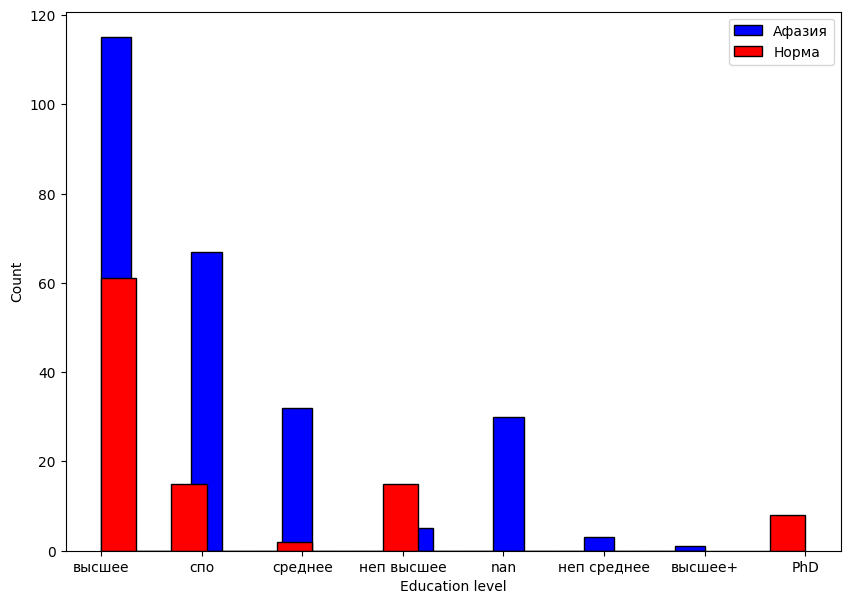

In [36]:
plt.figure(figsize=(10, 7))
plt.hist(meta_data_aphasia["Education level"].to_list(), bins=20, color="blue", label="Афазия", edgecolor='black')
plt.hist(meta_data_norm["Образование"].to_list(), bins=20, color="red", label="Норма", edgecolor='black')
plt.xlabel("Education level")
plt.ylabel("Count")
plt.legend();

Посмотрим на количество всех классов.

In [37]:
Counter(meta_data_aphasia["Education level"].to_list())

Counter({'высшее': 115,
         'спо': 67,
         'среднее': 32,
         nan: 30,
         'неп высшее': 5,
         'неп среднее': 3,
         'высшее+': 1})

In [38]:
Counter(meta_data_norm["Образование"].to_list())

Counter({'высшее': 61, 'спо': 15, 'неп высшее': 15, 'PhD': 8, 'среднее': 2})

### 2.4 Stroked hemisphere
Посмотрим на то, какое полушарие головного мозга поражено в большинстве случаев

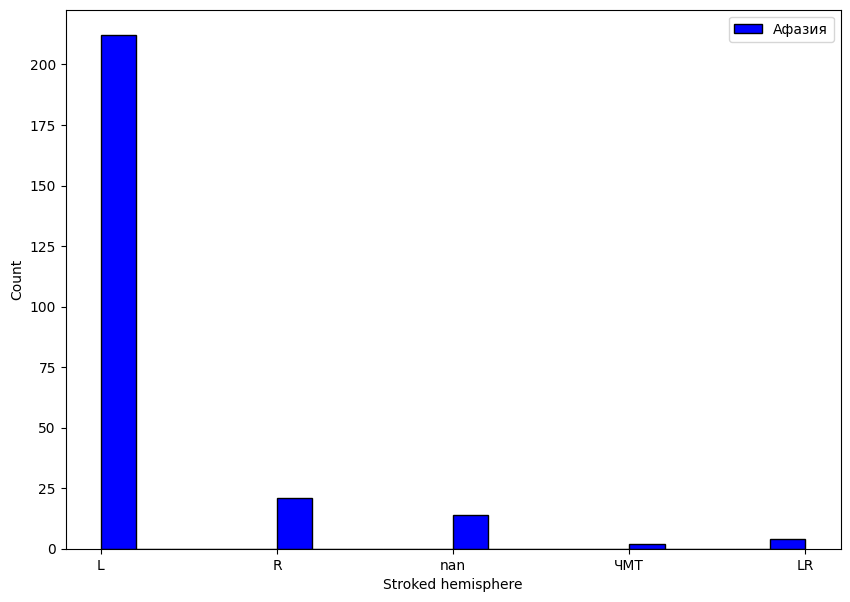

In [39]:
plt.figure(figsize=(10, 7))
plt.hist(meta_data_aphasia["Stroked hemisphere"].to_list(), bins=20, color="blue", label="Афазия", edgecolor='black')
plt.xlabel("Stroked hemisphere")
plt.ylabel("Count")
plt.legend();

### 2.5 Виды афазии

#### 2.5.1 Тяжесть заболевания

In [40]:
meta_data_aphasia["Aphasia/Norm"].drop_duplicates().values

array(['A'], dtype=object)

* 0 - no aphasia
* 1 - very mild
* 2 - mild
* 3 - mild-moderate
* 4 - moderate
* 5 - moderate-severe
* 6 - severe
* 7 - very severe

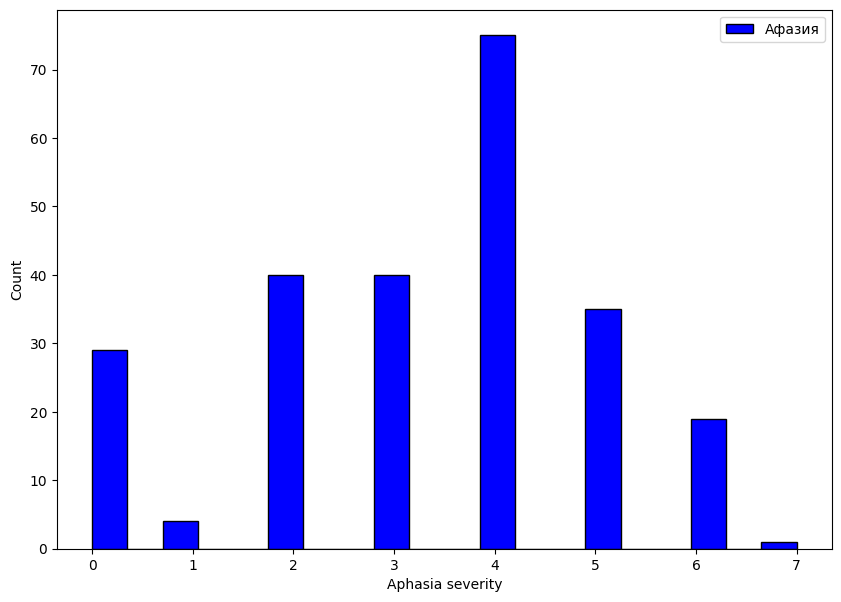

In [41]:
plt.figure(figsize=(10, 7))
plt.hist(meta_data_aphasia["Aphasia_Severity"].to_list(), bins=20, color="blue", label="Афазия", edgecolor='black')
plt.xlabel("Aphasia severity")
plt.ylabel("Count")
plt.legend();

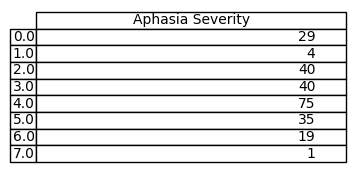

In [42]:
table = meta_data_aphasia["Aphasia_Severity"]
plt.figure(figsize=(4, 2))
plt.axis('off')
plt.table(cellText=[[c] for c in table.value_counts().sort_index()],
          rowLabels=[i for i in table.value_counts().sort_index().index],
          colLabels=["Aphasia Severity"],
          loc='center')

plt.show()

#### 2.5.2 Типы заболевания 

In [43]:
meta_data_aphasia["Aphasia_Types"].drop_duplicates().values

array(['1,5', '3,4', '1', '7,1,6', '3', '6', '5,6', 3, '5,2', '1,2', nan,
       6.5, '3,6', '4', '8,6', '4,1', 1, '4,3', 4.3, '8(когн нар-я)',
       '6,5', '4,2,1', '5,1', 8, '5', '3,2', '3,1', '1,2,3,6', '5,6,2',
       '1,2,3', '8', '3,5', '1,2,5', '6,3', 1.4, 1.6, 6.3, 4, 1.2, '0',
       3.6, 5, '4,6', '3,4,5', '1,6', 6, '1,4,6', '5,3', '3,7', '1,4',
       '5,6,1', '4,1,2', '6,8', 4.1, 2.1, 0], dtype=object)

Посмотрим, какие типы афазии встречаются чаще всего.

In [44]:
aphasia_types = []
aphasia_col = meta_data_aphasia["Aphasia_Types"].to_list()
for elem in aphasia_col:
    if pd.isnull(elem):
        aphasia_types.append(elem)
        continue
    elem = str(elem)
    if ',' in elem:
        to_add = elem.split(',')
        aphasia_types.extend([int(x) for x in to_add])
    elif '.' in elem:
        to_add = elem.split('.')
        aphasia_types.extend([int(x) for x in to_add])
    elif '(' in elem:
        to_add = elem.split('(')
        aphasia_types.extend([int(x) for x in to_add[:-1]])
    else:
        aphasia_types.append(int(elem))

Типы афазии:
1. efferent motor
2. afferent motor
3. complex motor
4. dynamic
5. acoustic-mnestic
6. sensory
7. semantic
8. other

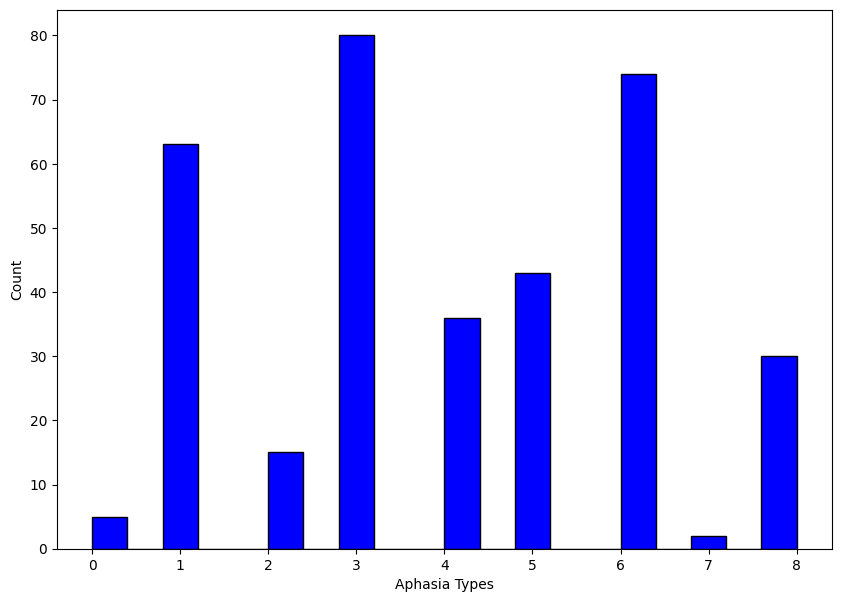

In [45]:
plt.figure(figsize=(10, 7))
plt.hist(aphasia_types, bins=20, color="blue", edgecolor='black')
plt.xlabel("Aphasia Types")
plt.ylabel("Count");

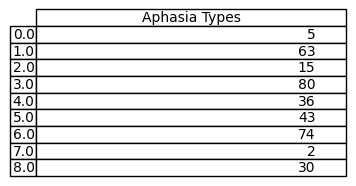

In [46]:
table = pd.Series(aphasia_types)
plt.figure(figsize=(4, 2))
plt.axis('off')
plt.table(cellText=[[c] for c in table.value_counts().sort_index()],
          rowLabels=[i for i in table.value_counts().sort_index().index],
          colLabels=["Aphasia Types"],
          loc='center')

plt.show()

#### 2.5.3 Преобладающий тип афазии у пациента

In [47]:
meta_data_aphasia["Dominant_Aphasia"].drop_duplicates().values

array([1, 3, 7, 2, 6, 5, nan, 4, '8(проводниковая)', '8(когн нар-я)',
       '8(нейродинамика)', 8, 0, '8(дизартрия)', '8(амнестическая)'],
      dtype=object)

In [48]:
meta_data_aphasia["Dominant_Aphasia"] = meta_data_aphasia["Dominant_Aphasia"].map({
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 0: 0, '8(проводниковая)': 8, '8(когн нар-я)': 8, '8(нейродинамика)': 8, '8(дизартрия)': 8, '8(амнестическая)': 8
})

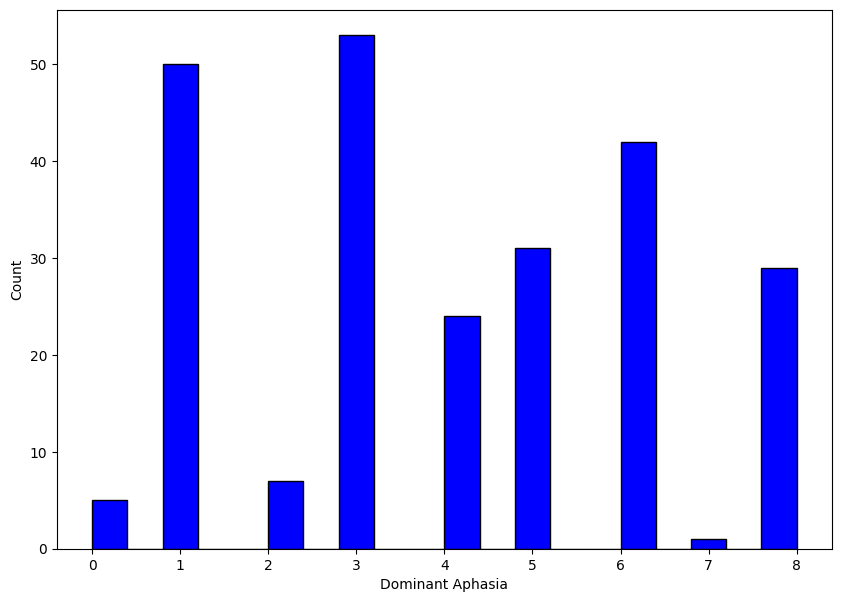

In [49]:
plt.figure(figsize=(10, 7))
plt.hist(meta_data_aphasia["Dominant_Aphasia"].to_list(), bins=20, color="blue", edgecolor='black')
plt.xlabel("Dominant Aphasia")
plt.ylabel("Count");

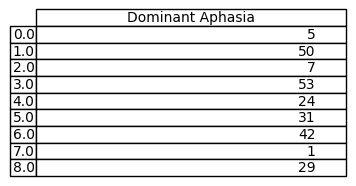

In [50]:
table = meta_data_aphasia["Dominant_Aphasia"]
plt.figure(figsize=(4, 2))
plt.axis('off')
plt.table(cellText=[[c] for c in table.value_counts().sort_index()],
          rowLabels=[i for i in table.value_counts().sort_index().index],
          colLabels=["Dominant Aphasia"],
          loc='center')
plt.show()

Графики не особо отличаются

### 2.6.1 Дизартрия

In [51]:
meta_data_aphasia["Dysarthria"].drop_duplicates().values

array([ 0.,  1., nan])

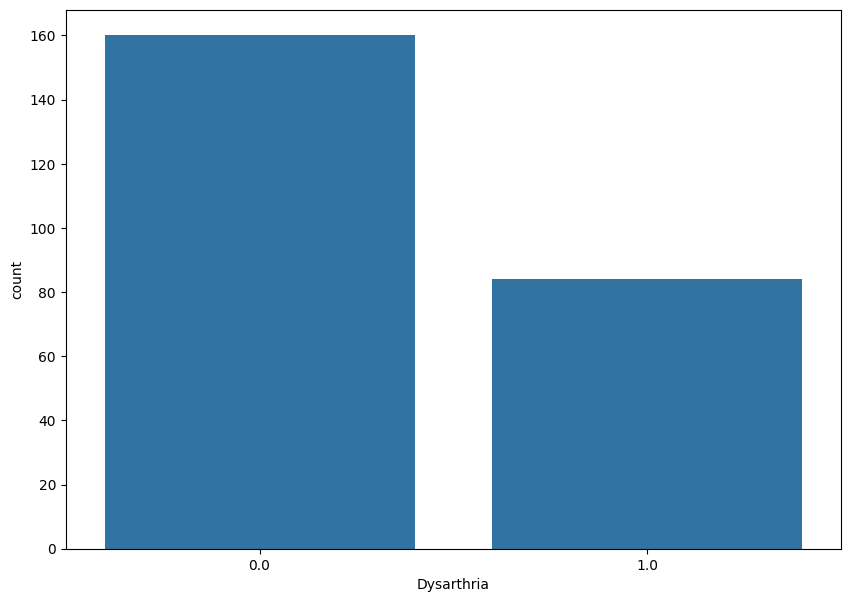

In [52]:
plt.figure(figsize=(10, 7))
sns.countplot(x=meta_data_aphasia["Dysarthria"]);

#### 2.6.2 Тяжесть дизартрии

In [53]:
meta_data_aphasia["Dysarthria_Severity"].drop_duplicates().values

array([ 0.,  1.,  4.,  3., nan,  5.,  6.,  2.])

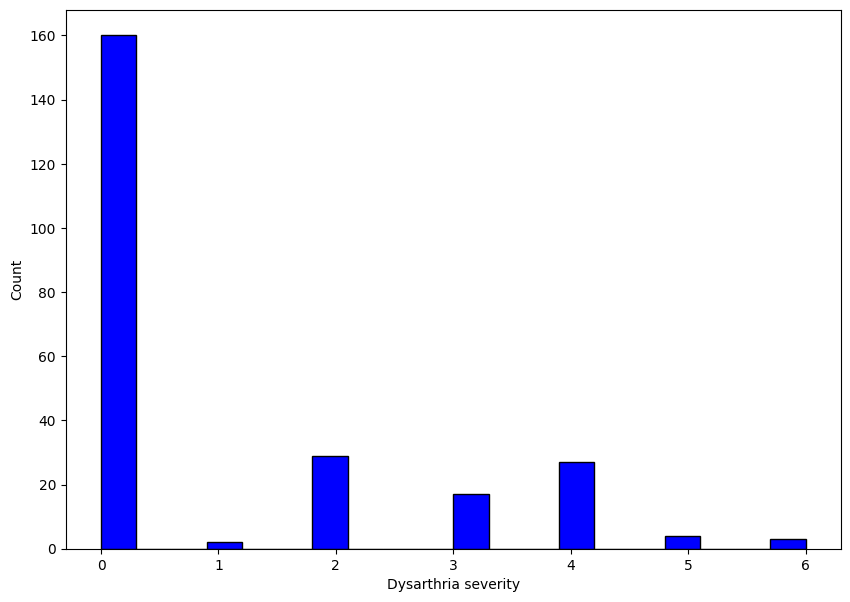

In [54]:
plt.figure(figsize=(10, 7))
plt.hist(meta_data_aphasia["Dysarthria_Severity"].to_list(), bins=20, color="blue", edgecolor='black')
plt.xlabel("Dysarthria severity")
plt.ylabel("Count");

Посмотрим сколько людей с дизартрией, без неё, и без заболеваний вообще.

In [55]:
aphasia_severity = meta_data_aphasia["Aphasia_Severity"].to_numpy()
dysarthria_severity = meta_data_aphasia["Dysarthria_Severity"].to_numpy()

In [56]:
print(f"Without aphasia, but with dysarthria: {np.sum((aphasia_severity == 0) * (dysarthria_severity > 0))}")

Without aphasia, but with dysarthria: 26


In [57]:
print(f"Without dysarthria, but with aphasia: {np.sum((aphasia_severity > 0) * (dysarthria_severity == 0))}")

Without dysarthria, but with aphasia: 156


In [58]:
print(f"Aphasia and dysarthria: {np.sum((aphasia_severity > 0) * (dysarthria_severity > 0))}")

Aphasia and dysarthria: 56


In [59]:
print(f"Without Aphasia and dysarthria: {np.sum((aphasia_severity == 0) * (dysarthria_severity == 0))}")

Without Aphasia and dysarthria: 3


Только один из двух действительно нет указанных заболевний, но есть конитивные расстройства

In [60]:
meta_data_aphasia[(meta_data_aphasia['Aphasia_Severity'] == 0) & (meta_data_aphasia['Dysarthria_Severity'] == 0)]

,Unnamed: 0,Subj_ID,Date_of_birth,Age,Sex (m/f),Education in years,Education level,Stroke_date,Stroked hemisphere,N of strokes,...,Time2.2_file_name,Time3.1_file_name,Time3.2_file_name,Time4.1_file_name,Time4.2_file_name,Time5.1_file_name,Time5.2_file_name,Time6.1_file_name,Time6.2_file_name,group
38,85-РАТ,251,1963-08-01 00:00:00,53,m,NaN,высшее,2016-09-25 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aphasia
321,NaN,1130,1954-11-29 00:00:00,69,f,"15,5",высшее,2020-10-14 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aphasia
352,NaN,1359,04.07.0195,70,f,15,высшее,2023-09-20 00:00:00,R,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aphasia


Испытуемый под номером 1359 говорит с небольшими дефектами, однако сложно сказать, болен ли он.

In [61]:
meta_data_aphasia['Dominant_Aphasia'] = meta_data_aphasia['Dominant_Aphasia'].apply(lambda x: int(x[0]) if '(' in str(x) else x)

In [62]:
print("Count of participants without records:", meta_data_aphasia.iloc[:, -12:].isna().all(axis=1).sum())

Count of participants without records: 0


#### 2.7 Количество аудиозаписей для каждого человка

In [63]:
aphasia_file_count = list(Counter(aphasia_filenames).values())
norm_file_count = list(Counter(norm_filenames).values())
all_file_count = aphasia_file_count + norm_file_count

Распределение количества аудиофайлов для каждого испытуемого с афазией

In [64]:
Counter(aphasia_file_count)

Counter({1: 93, 2: 84, 4: 44, 3: 17, 5: 7, 7: 5, 8: 4, 6: 3})

In [65]:
print(f"Среднее количество файлов для класса Aphasia: {sum(aphasia_file_count) / len(aphasia_file_count):.2f}")

Среднее количество файлов для класса Aphasia: 2.37


Распределение количества аудиофайлов для каждого испытуемого без афазии

In [66]:
Counter(norm_file_count)

Counter({2: 101})

In [67]:
print(f"Среднее количество файлов для класса Norm: {sum(norm_file_count) / len(norm_file_count):.2f}")

Среднее количество файлов для класса Norm: 2.00


Распределение количества аудиофайлов для каждого испытуемого

In [68]:
Counter(all_file_count)

Counter({2: 185, 1: 93, 4: 44, 3: 17, 5: 7, 7: 5, 8: 4, 6: 3})

In [69]:
print(f"Среднее количество файлов для каждого испытуемого: {sum(all_file_count) / len(all_file_count):.2f}")

Среднее количество файлов для каждого испытуемого: 2.26


## 3. Анализ аудиозаписей
Сначала переведём все аудиофайлы в .wav, т.к. большинство библиотек не работает с .3gp

In [70]:
NEW_DATA = os.path.join(DATA_PATH, "Voices_wav")
NEW_APHASIA = os.path.join(NEW_DATA, "Aphasia")
NEW_NORM = os.path.join(NEW_DATA, "Norm")

In [71]:
# for audio_file in os.listdir(APHASIA_PATH):
#     ffmpeg.input(os.path.join(APHASIA_PATH, audio_file)).output(os.path.join(NEW_APHASIA, audio_file[:-4] + '.wav')).run()

In [72]:
# for audio_file in os.listdir(NORM_PATH):
#     ffmpeg.input(os.path.join(NORM_PATH, audio_file)).output(os.path.join(NEW_NORM, audio_file[:-4] + '.wav')).run()

Для оценки качества звукозаписей будем использовать несколько метрик:
* RMS — считаем root mean square для аудио сигнала. Т.е. высчитываем среднюю громкость всей записи. Если RMS довольно высокий, то, возможно, это может быть следствием наличия шумов.
* Spectral Flatness — или же коэффициент тональности. Т.е. эта величина показывает насколько "гладкая" (отсутствуют пики) мощность сигнала. Если величина высокая (ближе к 1.0), то звук больше напоминает белый шум. Если же значение низкое, то наоборот. Формула расчёта: <br>$\mathrm{Flatness} = \frac{\sqrt[N]{\prod_{n=0}^{N-1}x(n)}}{\frac{\sum_{n=0}^{N-1}x(n)}{N}} = \frac{\exp\left(\frac{1}{N}\sum_{n=0}^{N-1} \ln x(n)\right)}{\frac{1}{N} \sum_{n=0}^{N-1}x(n)}$ 
<br> где x(n) — мощность спектра.
* Spectral Roll-Off — частота, на которой находится большая часть спектра сигнала. Высокое значение может означать, что в сигнале очень много высокочастотных компонент(шум, резкие звуки). Если же низкое значение, то это означать сосредоточение на низких частотах (гул, басс).

In [73]:
def rms(signal):
    return np.sqrt(np.mean(signal**2))

audio_quality_features = []

for audio_file in tqdm(os.listdir(NEW_APHASIA)):
    y, sr = librosa.load(os.path.join(NEW_APHASIA, audio_file), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    rms_value = rms(y)
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    roll_off = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    audio_quality_features.append([audio_file, duration, rms_value, spectral_flatness, roll_off])

100%|██████████| 608/608 [00:37<00:00, 16.39it/s]


In [74]:
df_audio_quality_aphasia = pd.DataFrame(audio_quality_features, columns=["file_name", "duration", "rms_value", "spectral_flatness", "roll_off"])
df_audio_quality_aphasia.head()

,file_name,duration,rms_value,spectral_flatness,roll_off
0,A-409-RAT-2-robb.wav,45.020000,0.030957,0.037325,1588.589755
1,A-681-RAT-3-robb.wav,92.700000,0.033755,0.038229,1683.148939
2,A-1052-RAT-1-bike.wav,55.054512,0.068966,0.006978,3608.729672
3,A-120-RAT-2-robb.wav,205.060000,0.021126,0.160914,2871.559331
4,A-145-RAT-1-bike.wav,91.440000,0.072746,0.008091,957.717372


In [75]:
audio_quality_features = []

for audio_file in tqdm(os.listdir(NEW_NORM)):
    y, sr = librosa.load(os.path.join(NEW_NORM, audio_file), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    rms_value = rms(y)
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    roll_off = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    audio_quality_features.append([audio_file, duration, rms_value, spectral_flatness, roll_off])

100%|██████████| 202/202 [00:04<00:00, 45.10it/s]


In [76]:
df_audio_quality_norm = pd.DataFrame(audio_quality_features, columns=["file_name", "duration", "rms_value", "spectral_flatness", "roll_off"])
df_audio_quality_norm.head()

,file_name,duration,rms_value,spectral_flatness,roll_off
0,N-0941-RAT-1-bike.wav,40.30,0.065215,0.066660,2082.335069
1,N-0995-RAT-1-bike.wav,48.46,0.050279,0.044317,2184.536816
2,N-1011-RAT-1-robb.wav,39.30,0.015791,0.143836,2544.042175
3,N-0982-RAT-1-robb.wav,38.58,0.059314,0.081281,2243.301721
4,N-1006-RAT-1-bike.wav,56.60,0.094168,0.066184,2049.646893


In [77]:
df_audio_quality_aphasia.describe()

,duration,rms_value,spectral_flatness,roll_off
count,608.000000,608.000000,608.000000,608.000000
mean,81.061094,0.048458,0.031463,1716.993592
std,51.682336,0.029054,0.039130,895.588373
min,7.180000,0.000033,0.002353,633.968054
25%,46.702222,0.026113,0.013383,1241.386128
50%,67.972063,0.042637,0.022131,1474.588512
75%,99.090000,0.065180,0.035750,1813.098106
max,427.500000,0.168308,0.688038,7077.025142


In [78]:
df_audio_quality_norm.describe()

,duration,rms_value,spectral_flatness,roll_off
count,202.000000,202.000000,202.000000,202.000000
mean,40.748416,0.065121,0.054272,1784.645118
std,22.020718,0.037527,0.032609,448.137677
min,14.400000,0.011289,0.003337,330.561414
25%,26.595000,0.036716,0.028764,1476.141538
50%,34.910000,0.055645,0.045730,1800.036458
75%,49.810000,0.087520,0.075037,2102.470314
max,144.180000,0.186925,0.155080,2845.199275


### 3.1 Длительность звукозаписи

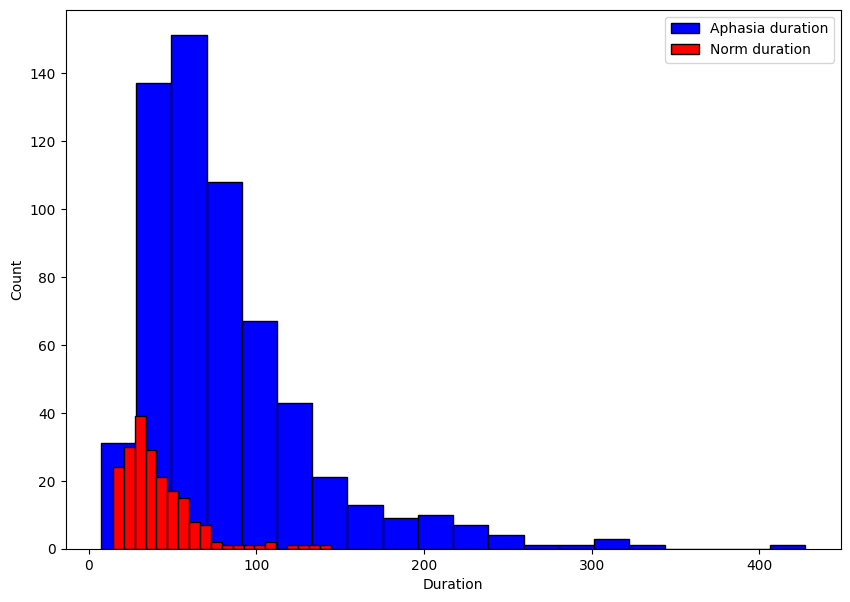

In [79]:
plt.figure(figsize=(10, 7), )
plt.hist(df_audio_quality_aphasia["duration"].to_list(), bins=20, color="blue", label="Aphasia duration", edgecolor='black')
plt.hist(df_audio_quality_norm["duration"].to_list(), bins=20, color="red", label="Norm duration", edgecolor='black')
plt.xlabel("Duration")
plt.ylabel("Count")
plt.legend();

 Статистики продолжительности аудио файлов у людей с афазией

In [80]:
df_audio_quality_aphasia["duration"].describe()

count    608.000000
mean      81.061094
std       51.682336
min        7.180000
25%       46.702222
50%       67.972063
75%       99.090000
max      427.500000
Name: duration, dtype: float64

 Статистики продолжительности аудио файлов у людей без афазии

In [81]:
df_audio_quality_norm["duration"].describe()

count    202.000000
mean      40.748416
std       22.020718
min       14.400000
25%       26.595000
50%       34.910000
75%       49.810000
max      144.180000
Name: duration, dtype: float64

### 3.2 RMS

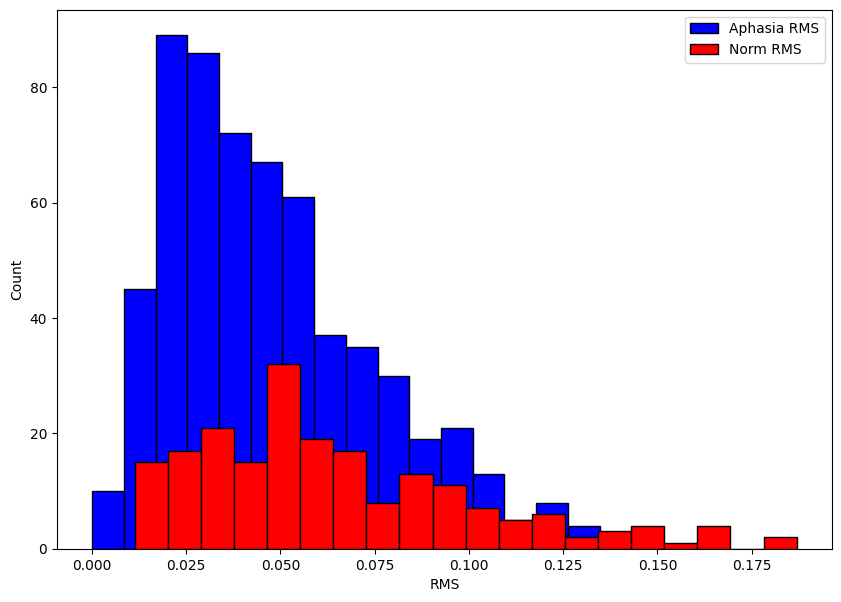

In [82]:
plt.figure(figsize=(10, 7), )
plt.hist(df_audio_quality_aphasia["rms_value"].to_list(), bins=20, color="blue", label="Aphasia RMS", edgecolor='black')
plt.hist(df_audio_quality_norm["rms_value"].to_list(), bins=20, color="red", label="Norm RMS", edgecolor='black')
plt.xlabel("RMS")
plt.ylabel("Count")
plt.legend();

In [83]:
df_audio_quality_aphasia.nlargest(5, columns=['rms_value'])

,file_name,duration,rms_value,spectral_flatness,roll_off
337,A-1342-RAT-1-bike.wav,25.40263,0.168308,0.014649,5793.976050
105,A-820-RAT-1-bike.wav,51.82000,0.149516,0.021020,1303.882137
390,A-224-RAT-2-bike.wav,21.38000,0.146005,0.032139,1277.098881
37,A-820-RAT-1-robb.wav,35.50000,0.143091,0.025839,1371.635698
101,A-820-RAT-2-bike.wav,51.68000,0.140819,0.019219,1275.874072


In [84]:
df_audio_quality_aphasia.nsmallest(5, columns=['rms_value'])

,file_name,duration,rms_value,spectral_flatness,roll_off
327,A-928-RAT-1-robb.wav,25.56,0.000033,0.688038,2020.849609
439,A-260-RAT-1-bike.wav,27.68,0.002172,0.022087,1220.427973
583,A-505-RAT-1-bike.wav,36.04,0.003160,0.065826,2055.657137
71,A-260-RAT-3-robb.wav,18.80,0.003810,0.128243,2390.811012
60,A-387-RAT-1-bike.wav,90.98,0.005060,0.066954,2043.617045


In [85]:
df_audio_quality_norm.nlargest(5, columns=['rms_value'])

,file_name,duration,rms_value,spectral_flatness,roll_off
149,N-1008-RAT-1-robb.wav,80.36,0.186925,0.027966,2098.334246
57,N-0916-RAT-1-bike.wav,68.48,0.180357,0.027870,1441.672502
144,N-0916-RAT-1-robb.wav,28.20,0.165062,0.028180,1629.517432
20,N-1008-RAT-1-bike.wav,71.54,0.163322,0.037011,2288.349732
14,N-1017-RAT-1-bike.wav,40.00,0.162778,0.055435,2227.361222


In [86]:
df_audio_quality_norm.nsmallest(5, columns=['rms_value'])

,file_name,duration,rms_value,spectral_flatness,roll_off
77,N-0929-RAT-1-bike.wav,95.28,0.011289,0.003337,427.630751
179,N-0962-RAT-1-robb.wav,45.06,0.011850,0.015134,1005.740248
84,N-0960-RAT-1-bike.wav,55.12,0.012032,0.036905,1272.177712
191,N-0986-RAT-1-bike.wav,18.40,0.014360,0.059139,2120.795356
101,N-0912-RAT-1-robb.wav,31.24,0.014531,0.007838,330.561414


### 3.3 Spectral flatness
Если значения близки к 0, то сигнал чистый, если > 0.6, то довольно шумный. 

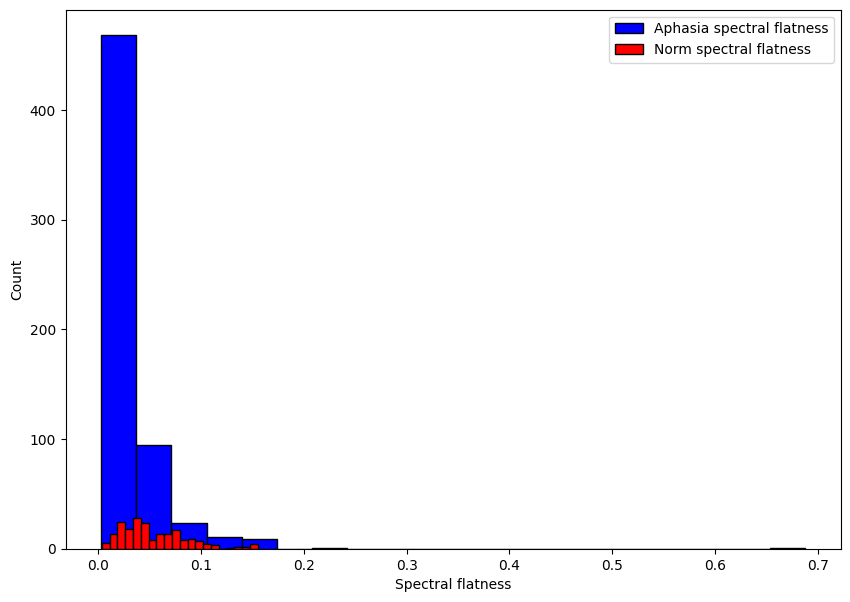

In [87]:
plt.figure(figsize=(10, 7))
plt.hist(df_audio_quality_aphasia["spectral_flatness"].to_list(), bins=20, color="blue", label="Aphasia spectral flatness", edgecolor='black')
plt.hist(df_audio_quality_norm["spectral_flatness"].to_list(), bins=20, color="red", label="Norm spectral flatness", edgecolor='black')
plt.xlabel("Spectral flatness")
plt.ylabel("Count")
plt.legend();

In [88]:
df_audio_quality_aphasia.nlargest(5, columns=['spectral_flatness'])

,file_name,duration,rms_value,spectral_flatness,roll_off
327,A-928-RAT-1-robb.wav,25.56,0.000033,0.688038,2020.849609
175,A-120-RAT-1-robb.wav,204.94,0.012462,0.212196,2852.696691
340,A-233-RAT-1-bike.wav,97.80,0.009695,0.170631,2642.423561
29,A-120-RAT-2-bike.wav,237.46,0.021707,0.168104,2848.472026
589,A-196-RAT-1-robb.wav,84.42,0.025061,0.167879,2854.456676


In [89]:
df_audio_quality_aphasia.nsmallest(5, columns=['spectral_flatness'])

,file_name,duration,rms_value,spectral_flatness,roll_off
11,A-1309-RAT-1-bike.wav,222.958005,0.036142,0.002353,3143.265738
560,A-480-RAT-1-robb.wav,209.840000,0.011517,0.003391,633.968054
167,A-1352-RAT-1-bike.wav,117.028571,0.076647,0.003657,4580.407716
202,A-1360-RAT-1-bike.wav,112.802540,0.080100,0.004187,4096.609347
79,A-1354-RAT-1-bike.wav,92.670839,0.049441,0.004532,4445.507262


In [90]:
df_audio_quality_norm.nlargest(5, columns=['spectral_flatness'])

,file_name,duration,rms_value,spectral_flatness,roll_off
194,N-0992-RAT-1-bike.wav,35.40,0.065966,0.155080,2519.051782
49,N-0928-RAT-1-robb.wav,33.16,0.068879,0.152084,1660.020773
70,N-0992-RAT-1-robb.wav,49.52,0.066779,0.150519,2548.414285
171,N-0924-RAT-1-robb.wav,42.04,0.020028,0.149088,2103.578054
31,N-0998-RAT-1-bike.wav,47.88,0.036517,0.145665,2522.910756


In [91]:
df_audio_quality_norm.nsmallest(5, columns=['spectral_flatness'])

,file_name,duration,rms_value,spectral_flatness,roll_off
77,N-0929-RAT-1-bike.wav,95.28,0.011289,0.003337,427.630751
27,N-0929-RAT-1-robb.wav,66.62,0.017814,0.005526,806.030860
101,N-0912-RAT-1-robb.wav,31.24,0.014531,0.007838,330.561414
26,N-0961-RAT-1-robb.wav,35.08,0.045482,0.010214,570.099044
140,N-0967-RAT-1-bike.wav,41.58,0.135288,0.010806,949.723558


### 3.4 Spectral Roll-off
Если значения довольно высокие (> 6 кГц), то, возможно, в записи много шумов.

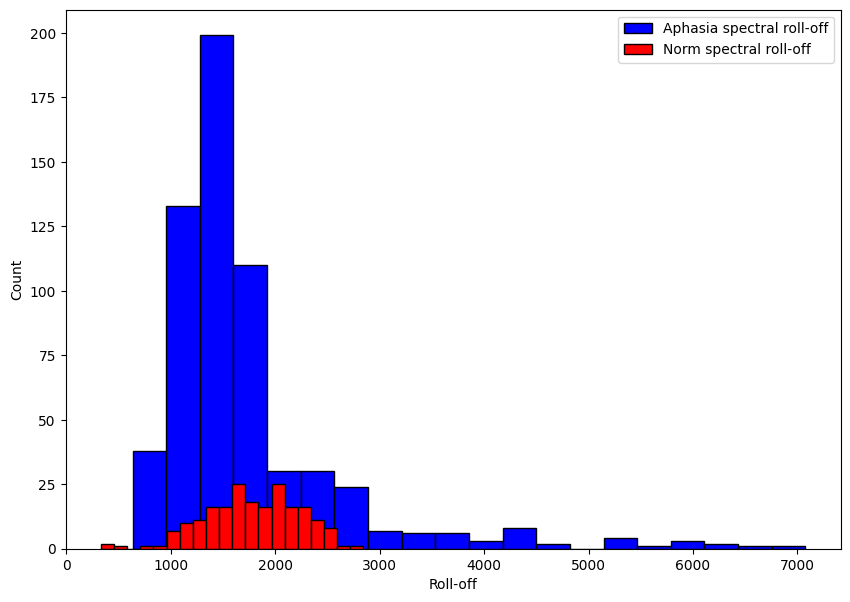

In [92]:
plt.figure(figsize=(10, 7))
plt.hist(df_audio_quality_aphasia["roll_off"].to_list(), bins=20, color="blue", label="Aphasia spectral roll-off", edgecolor='black')
plt.hist(df_audio_quality_norm["roll_off"].to_list(), bins=20, color="red", label="Norm spectral roll-off", edgecolor='black')
plt.xlabel("Roll-off")
plt.ylabel("Count")
plt.legend();

In [93]:
df_audio_quality_aphasia.nlargest(5, columns=['roll_off'])

,file_name,duration,rms_value,spectral_flatness,roll_off
329,A-1016-RAT-1-bike.wav,90.882902,0.061742,0.005860,7077.025142
467,A-1071-RAT-1-bike.wav,101.378322,0.035528,0.006283,6603.426859
496,A-1308-RAT-1-bike.wav,40.681361,0.019456,0.010234,6338.840510
245,A-103-RAT-1-bike.wav,102.353560,0.097427,0.005486,6116.220972
491,A-1329-RAT-1-bike.wav,107.624490,0.047770,0.004581,5864.296471


In [94]:
df_audio_quality_aphasia.nsmallest(5, columns=['roll_off'])

,file_name,duration,rms_value,spectral_flatness,roll_off
560,A-480-RAT-1-robb.wav,209.84,0.011517,0.003391,633.968054
308,A-13-RAT-2-robb.wav,70.70,0.048918,0.005990,715.342195
592,A-732-RAT-1-robb.wav,75.10,0.025182,0.005891,716.880057
168,A-257-RAT-3-bike.wav,75.18,0.023437,0.006383,735.837766
486,A-257-RAT-1-bike.wav,75.18,0.023437,0.006383,735.837766


In [95]:
df_audio_quality_norm.nlargest(5, columns=['roll_off'])

,file_name,duration,rms_value,spectral_flatness,roll_off
133,N-1016-RAT-1-bike.wav,22.04,0.106128,0.071664,2845.199275
83,N-1016-RAT-1-robb.wav,15.28,0.100793,0.064883,2644.089958
109,N-0996-RAT-1-bike.wav,100.66,0.055221,0.108750,2576.975226
116,N-0996-RAT-1-robb.wav,88.34,0.061934,0.087411,2572.592324
70,N-0992-RAT-1-robb.wav,49.52,0.066779,0.150519,2548.414285


In [96]:
df_audio_quality_norm.nsmallest(5, columns=['roll_off'])

,file_name,duration,rms_value,spectral_flatness,roll_off
101,N-0912-RAT-1-robb.wav,31.24,0.014531,0.007838,330.561414
77,N-0929-RAT-1-bike.wav,95.28,0.011289,0.003337,427.630751
26,N-0961-RAT-1-robb.wav,35.08,0.045482,0.010214,570.099044
27,N-0929-RAT-1-robb.wav,66.62,0.017814,0.005526,806.030860
140,N-0967-RAT-1-bike.wav,41.58,0.135288,0.010806,949.723558


Статистики для spectral roll-off

In [97]:
df_audio_quality_norm["roll_off"].describe()

count     202.000000
mean     1784.645118
std       448.137677
min       330.561414
25%      1476.141538
50%      1800.036458
75%      2102.470314
max      2845.199275
Name: roll_off, dtype: float64

## 4. Анализ промежутков тишины и речи

In [98]:
speech_model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad')

Using cache found in /home/zakhar/.cache/torch/hub/snakers4_silero-vad_master


In [99]:
(get_speech_timestamps, _, read_audio, _, _) = utils

In [100]:
def get_speech_and_silence_timestamps(dir_name: str):
    output = []
    for audio_file in tqdm(os.listdir(dir_name)):
        y, sr = librosa.load(os.path.join(dir_name, audio_file), sr=8000)
        duration = librosa.get_duration(y=y, sr=sr)
        
        speech_timestamps = get_speech_timestamps(y, speech_model, threshold=0.75, min_speech_duration_ms=500, min_silence_duration_ms=1000, sampling_rate=sr, return_seconds=True)
        
        silence_timestamps = []
        speech_duration = 0
        speech_end = 0
        
        for x in speech_timestamps:
            silence_timestamps.append({'start': speech_end, 'end': x['start'] - speech_end})
            speech_duration += x['end'] - x['start']
            
            speech_end = x['end']
        silence_timestamps.append({'start': speech_end, 'end': duration - speech_end})
        
        mean_speach_duration = 0
        if len(speech_timestamps) > 0:
            mean_speach_duration = speech_duration / len(speech_timestamps)
        mean_silence_duration = 0
        if len(silence_timestamps) > 0:
            mean_silence_duration = (duration - speech_duration) / len(silence_timestamps) 
        
        output.append([audio_file, speech_duration, len(speech_timestamps), speech_timestamps, mean_speach_duration, duration - speech_duration, len(silence_timestamps), silence_timestamps, mean_silence_duration])
    return output

In [101]:
aphasia_timestamps = get_speech_and_silence_timestamps(NEW_APHASIA)

100%|██████████| 608/608 [03:18<00:00,  3.07it/s]


In [102]:
norm_timestamps = get_speech_and_silence_timestamps(NEW_NORM)

100%|██████████| 202/202 [00:33<00:00,  5.99it/s]


In [103]:
df_aphasia_timestamps = pd.DataFrame(aphasia_timestamps, columns=["file_name", "duration_of_speech", "count_of_speech", "speech_timestamps", "mean_speach_duration", "duration_of_silence", "count_of_silence", "silence_timestamps", "mean_silence_duration"])
df_norm_timestamps = pd.DataFrame(norm_timestamps, columns=["file_name", "duration_of_speech", "count_of_speech", "speech_timestamps", "mean_speach_duration", "duration_of_silence", "count_of_silence", "silence_timestamps", "mean_silence_duration"])

In [104]:
df_aphasia_timestamps.head()

,file_name,duration_of_speech,count_of_speech,speech_timestamps,mean_speach_duration,duration_of_silence,count_of_silence,silence_timestamps,mean_silence_duration
0,A-409-RAT-2-robb.wav,20.400000,11,"[{'start': 5.7, 'end': 9.2}, {'start': 10.2, '...",1.854545,24.62,12,"[{'start': 0, 'end': 5.7}, {'start': 9.2, 'end...",2.051667
1,A-681-RAT-3-robb.wav,31.400000,12,"[{'start': 8.0, 'end': 8.9}, {'start': 11.6, '...",2.616667,61.30,13,"[{'start': 0, 'end': 8.0}, {'start': 8.9, 'end...",4.715385
2,A-1052-RAT-1-bike.wav,36.254625,4,"[{'start': 10.6, 'end': 36.4}, {'start': 38.9,...",9.063656,18.80,5,"[{'start': 0, 'end': 10.6}, {'start': 36.4, 'e...",3.760000
3,A-120-RAT-2-robb.wav,36.660000,20,"[{'start': 31.3, 'end': 32.1}, {'start': 42.4,...",1.833000,168.40,21,"[{'start': 0, 'end': 31.3}, {'start': 32.1, 'e...",8.019048
4,A-145-RAT-1-bike.wav,62.100000,13,"[{'start': 4.2, 'end': 6.4}, {'start': 7.8, 'e...",4.776923,29.34,14,"[{'start': 0, 'end': 4.2}, {'start': 6.4, 'end...",2.095714


In [105]:
df_aphasia_timestamps.describe()

,duration_of_speech,count_of_speech,mean_speach_duration,duration_of_silence,count_of_silence,mean_silence_duration
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000
mean,40.611305,9.175987,5.998842,40.449793,10.175987,4.317013
std,22.872952,6.253325,5.784263,42.827363,6.253325,6.190454
min,0.000000,0.000000,0.000000,0.300000,1.000000,0.150000
25%,25.475000,5.000000,3.004500,14.375000,6.000000,2.056250
50%,36.660000,8.000000,4.416667,26.150000,9.000000,2.810556
75%,51.291000,12.000000,6.812768,51.400000,13.000000,4.163750
max,190.980000,41.000000,73.200000,352.000000,42.000000,57.370000


In [106]:
df_norm_timestamps.describe()

,duration_of_speech,count_of_speech,mean_speach_duration,duration_of_silence,count_of_silence,mean_silence_duration
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,29.730000,4.252475,10.483028,11.018416,5.252475,2.091850
std,18.840059,3.004246,9.986447,10.013276,3.004246,2.488808
min,0.000000,0.000000,0.000000,0.400000,1.000000,0.200000
25%,18.375000,2.000000,4.216667,4.505000,3.000000,1.283393
50%,25.200000,4.000000,7.085000,8.710000,5.000000,1.824000
75%,35.195000,6.000000,12.887500,15.095000,7.000000,2.200000
max,123.860000,21.000000,78.660000,85.680000,22.000000,31.240000


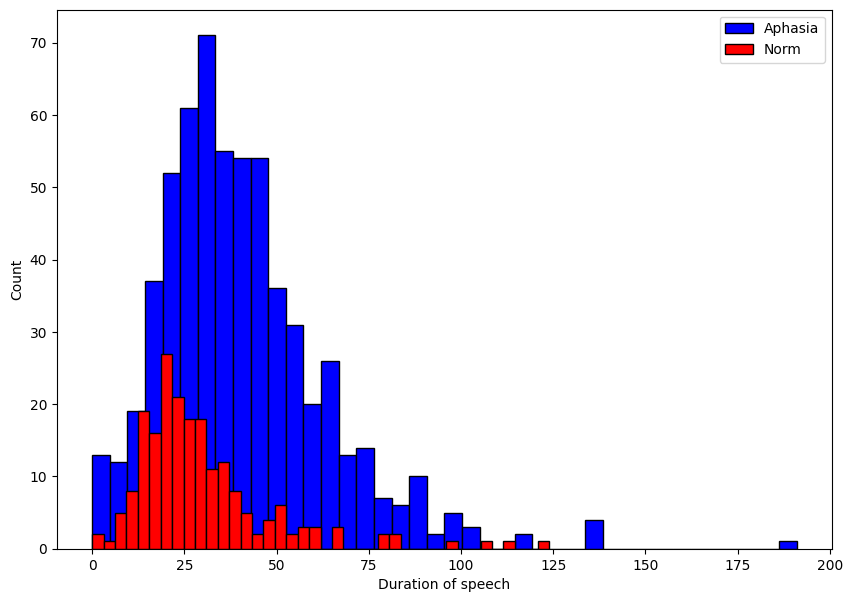

In [107]:
plt.figure(figsize=(10, 7))
plt.hist(df_aphasia_timestamps["duration_of_speech"].to_list(), bins=40, color="blue", label="Aphasia", edgecolor='black')
plt.hist(df_norm_timestamps["duration_of_speech"].to_list(), bins=40, color="red", label="Norm", edgecolor='black')
plt.xlabel("Duration of speech")
plt.ylabel("Count")
plt.legend();

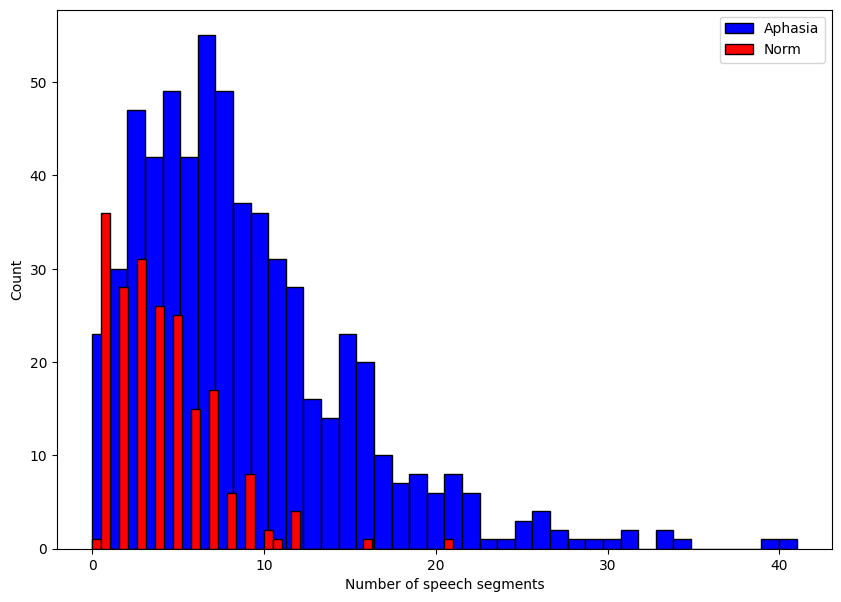

In [108]:
plt.figure(figsize=(10, 7))
plt.hist(df_aphasia_timestamps["count_of_speech"].to_list(), bins=40, color="blue", label="Aphasia", edgecolor='black')
plt.hist(df_norm_timestamps["count_of_speech"].to_list(), bins=40, color="red", label="Norm", edgecolor='black')
plt.xlabel("Number of speech segments")
plt.ylabel("Count")
plt.legend();

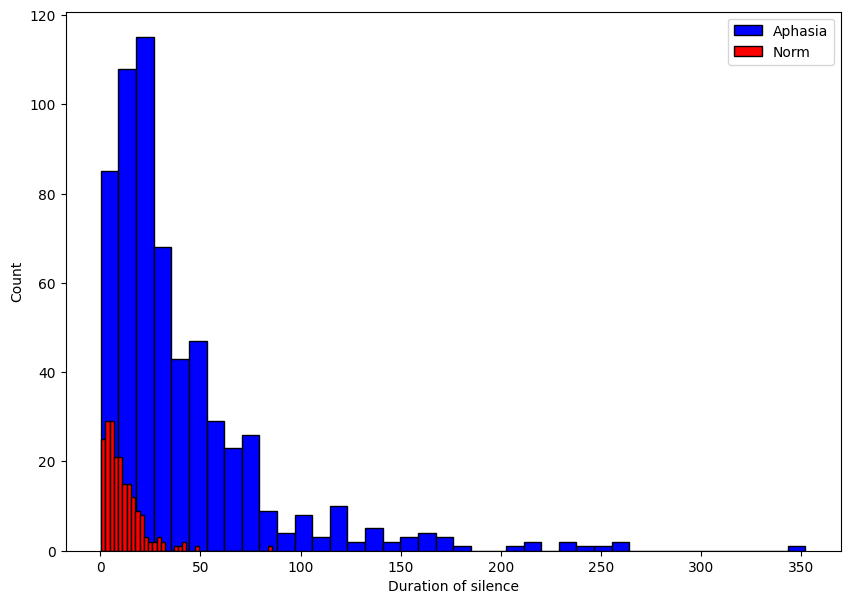

In [109]:
plt.figure(figsize=(10, 7))
plt.hist(df_aphasia_timestamps["duration_of_silence"].to_list(), bins=40, color="blue", label="Aphasia", edgecolor='black')
plt.hist(df_norm_timestamps["duration_of_silence"].to_list(), bins=40, color="red", label="Norm", edgecolor='black')
plt.xlabel("Duration of silence")
plt.ylabel("Count")
plt.legend();

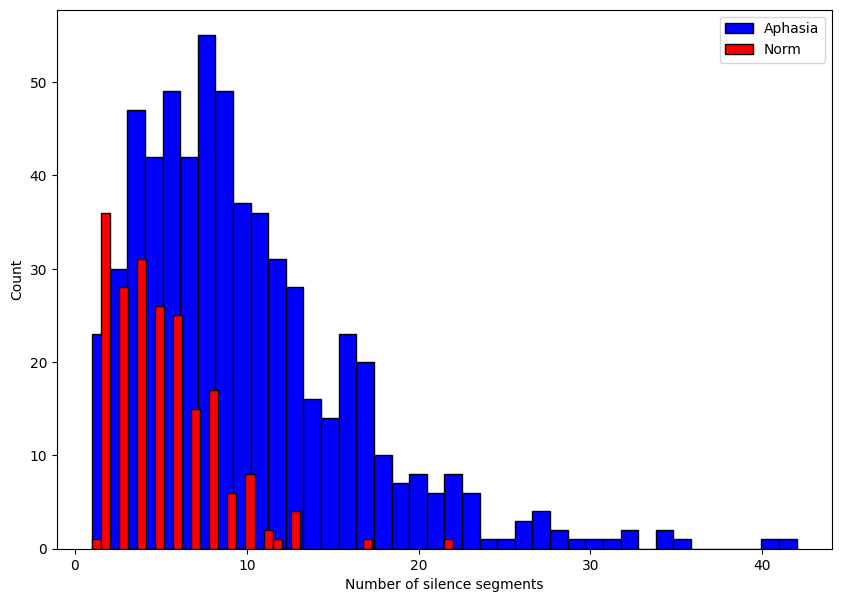

In [110]:
plt.figure(figsize=(10, 7))
plt.hist(df_aphasia_timestamps["count_of_silence"].to_list(), bins=40, color="blue", label="Aphasia", edgecolor='black')
plt.hist(df_norm_timestamps["count_of_silence"].to_list(), bins=40, color="red", label="Norm", edgecolor='black')
plt.xlabel("Number of silence segments")
plt.ylabel("Count")
plt.legend();

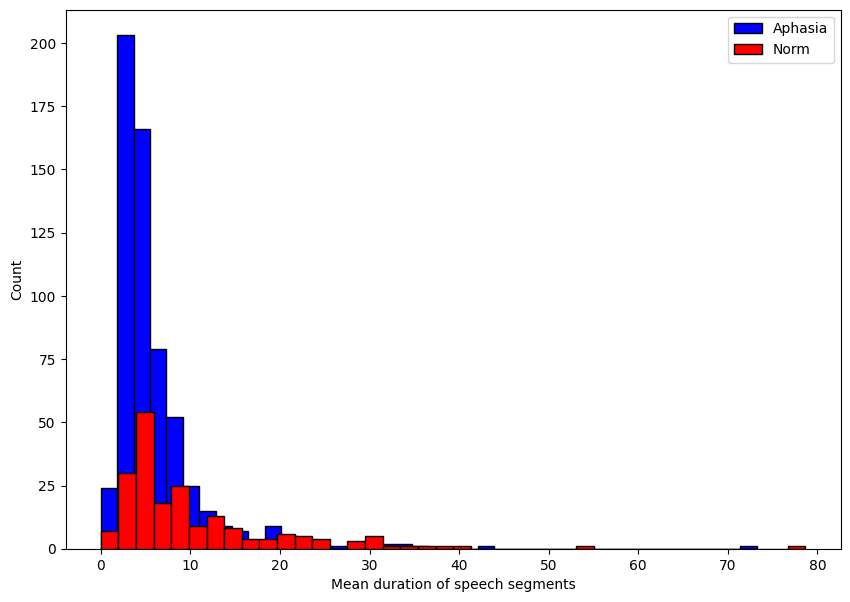

In [111]:
plt.figure(figsize=(10, 7))
plt.hist(df_aphasia_timestamps["mean_speach_duration"].to_list(), bins=40, color="blue", label="Aphasia", edgecolor='black')
plt.hist(df_norm_timestamps["mean_speach_duration"].to_list(), bins=40, color="red", label="Norm", edgecolor='black')
plt.xlabel("Mean duration of speech segments")
plt.ylabel("Count")
plt.legend();

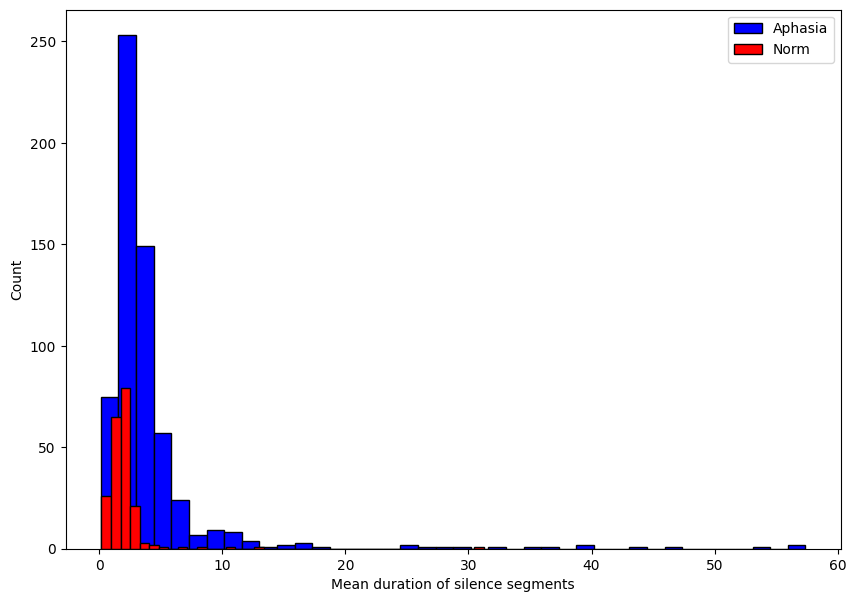

In [112]:
plt.figure(figsize=(10, 7))
plt.hist(df_aphasia_timestamps["mean_silence_duration"].to_list(), bins=40, color="blue", label="Aphasia", edgecolor='black')
plt.hist(df_norm_timestamps["mean_silence_duration"].to_list(), bins=40, color="red", label="Norm", edgecolor='black')
plt.xlabel("Mean duration of silence segments")
plt.ylabel("Count")
plt.legend();

In [113]:
# df_aphasia_timestamps.to_csv(os.path.join("..", "data", "aphasia_timestamps.csv"), index=False)
# df_norm_timestamps.to_csv(os.path.join("..", "data", "norm_timestamps.csv"), index=False)